In [ ]:
# !git clone https://github.com/LinaNourr/Head-Pose-Estimation-Project.git

Cloning into 'Head-Pose-Estimation-Project'...


In [ ]:
%%capture
!pip install mediapipe


In [ ]:
import numpy as np
import os,cv2,math,glob,random
import scipy.io as sio
from math import cos, sin
from pathlib import Path
import pandas as pd
import mediapipe
import warnings
warnings.filterwarnings('ignore')
from google.colab.patches import cv2_imshow
from google.colab import files
import time

In [ ]:
!unzip /content/AFLW2000-3D.zip

Archive:  /content/AFLW2000-3D.zip
   creating: AFLW2000/
   creating: AFLW2000/Code/
  inflating: AFLW2000/Code/DrawSolidHead.m  
  inflating: AFLW2000/Code/DrawTextureHead.m  
  inflating: AFLW2000/Code/main_show_without_BFM.m  
  inflating: AFLW2000/Code/main_show_with_BFM.m  
   creating: AFLW2000/Code/Mex/
  inflating: AFLW2000/Code/Mex/compile.m  
  inflating: AFLW2000/Code/Mex/Tnorm_Vnorm.h  
  inflating: AFLW2000/Code/Mex/Tnorm_VnormC.cpp  
  inflating: AFLW2000/Code/Mex/Tnorm_VnormC.mexw64  
   creating: AFLW2000/Code/ModelGeneration/
  inflating: AFLW2000/Code/ModelGeneration/ModelGenerate.m  
  inflating: AFLW2000/Code/ModelGeneration/model_info.mat  
  inflating: AFLW2000/Code/Model_Exp.mat  
  inflating: AFLW2000/Code/Model_Shape_Sim.mat  
  inflating: AFLW2000/Code/NormDirection.m  
  inflating: AFLW2000/Code/readme.txt  
  inflating: AFLW2000/Code/RotationMatrix.m  
  inflating: AFLW2000/Code/Tnorm_VnormC.mexw64  
  inflating: AFLW2000/image00002.jpg  
  inflating: AFLW2

In [ ]:
%%capture
if os.path.isfile('/content/AFLW2000-3D.zip') == False:
  !gdown --id  1fP3zvSCYjll_o_m7S12nvQLZ9MnsEoap
  !unzip /content/AFLW2000-3D.zip

In [ ]:
def draw_axis(img, pitch,yaw,roll, tdx=None, tdy=None, size = 100):

    yaw = -yaw
    if tdx != None and tdy != None:
        tdx = tdx
        tdy = tdy
    else:
        height, width = img.shape[:2]
        tdx = width / 2
        tdy = height / 2

    # X-Axis pointing to right. drawn in red
    x1 = size * (cos(yaw) * cos(roll)) + tdx
    y1 = size * (cos(pitch) * sin(roll) + cos(roll) * sin(pitch) * sin(yaw)) + tdy

    # Y-Axis | drawn in green
    #        v
    x2 = size * (-cos(yaw) * sin(roll)) + tdx
    y2 = size * (cos(pitch) * cos(roll) - sin(pitch) * sin(yaw) * sin(roll)) + tdy

    # Z-Axis (out of the screen) drawn in blue
    x3 = size * (sin(yaw)) + tdx
    y3 = size * (-cos(yaw) * sin(pitch)) + tdy

    cv2.line(img, (int(tdx), int(tdy)), (int(x1),int(y1)),(0,0,255),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x2),int(y2)),(0,255,0),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x3),int(y3)),(255,0,0),2)

    return img

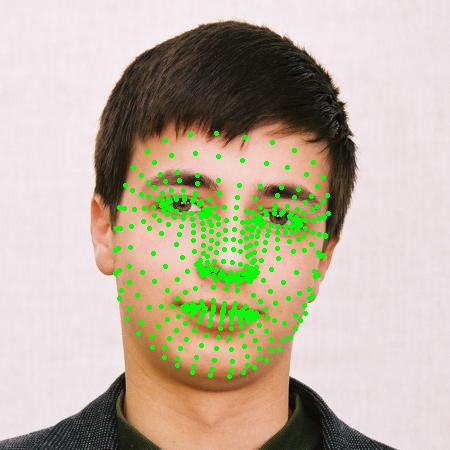

In [ ]:
random_file = 'image00060'

faceModule = mediapipe.solutions.face_mesh
with faceModule.FaceMesh(static_image_mode=True) as faces:

    image = cv2.imread('/content/AFLW2000/'+random_file+'.jpg')
    # processing the face to extract the landmark points (468 point) for each x,y,z
    results = faces.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    if results.multi_face_landmarks != None:
      for face in results.multi_face_landmarks:
          for landmark in face.landmark:
              x = landmark.x
              y = landmark.y
              shape = image.shape
              relative_x = int(x * shape[1])
              relative_y = int(y * shape[0])
              cv2.circle(image, (relative_x, relative_y), radius=1, color=(0, 255, 0), thickness=2)
      cv2_imshow(image)

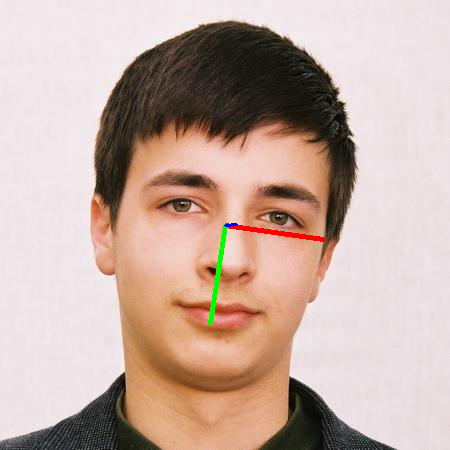

In [ ]:
image = cv2.imread('/content/AFLW2000/'+random_file+'.jpg')
mat_file = sio.loadmat('/content/AFLW2000/'+random_file+'.mat')
pose_para = mat_file["Pose_Para"][0][:3]
pitch = pose_para[0]
yaw = pose_para[1]
roll = pose_para[2]
cv2_imshow(draw_axis(image,pitch,yaw,roll))


In [ ]:
landmarks_dict = {}
faceModule = mediapipe.solutions.face_mesh

with faceModule.FaceMesh(static_image_mode=True) as faces:

    for image_index in range(4776):
      try:
        random_file = 'image'+ str(image_index).zfill(5)
        mat_file = sio.loadmat('./AFLW2000/'+random_file+'.mat')
        pitch,yaw,roll = mat_file["Pose_Para"][0][:3]

        landmarks_dict[random_file] = {'pitch':pitch,'yaw':yaw,'roll':roll}
        image = cv2.imread('/content/AFLW2000/'+random_file+'.jpg')
        results = faces.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        if results.multi_face_landmarks != None:
          for face in results.multi_face_landmarks:
              for i,landmark in enumerate(face.landmark):
                  x = landmark.x
                  y = landmark.y
                  landmarks_dict[random_file]["x_"+str(i)] = x
                  landmarks_dict[random_file]["y_"+str(i)] = y

      except:
        pass

In [ ]:
df = pd.DataFrame.from_dict(landmarks_dict,orient='index').reset_index()
df

,index,pitch,yaw,roll,x_0,y_0,x_1,y_1,x_2,y_2,...,x_463,y_463,x_464,y_464,x_465,y_465,x_466,y_466,x_467,y_467
0,image00002,-0.399231,0.018227,0.085676,0.485651,0.686890,0.489194,0.639721,0.489802,0.647256,...,0.559712,0.485137,0.548437,0.492813,0.541429,0.500371,0.665668,0.471336,0.676091,0.464005
1,image00004,0.470065,1.189533,0.300959,0.441502,0.642091,0.417273,0.592251,0.448839,0.610546,...,0.522467,0.506956,0.511393,0.511724,0.500658,0.514913,0.584451,0.500244,0.594060,0.495387
2,image00006,-0.184650,0.881137,-0.236852,0.317797,0.799190,0.321328,0.776498,0.318316,0.782066,...,0.334413,0.717794,0.330334,0.720868,0.328639,0.723342,0.373404,0.713071,0.377643,0.709798
3,image00008,-0.175379,0.299208,-0.373374,0.503922,0.694309,0.469521,0.653913,0.489504,0.658751,...,0.507567,0.500958,0.497731,0.510606,0.490586,0.518652,0.595615,0.455611,0.602670,0.444623
4,image00010,-0.882169,1.198004,-1.033374,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,image04358,-0.197102,-0.070430,0.105118,0.491617,0.692910,0.500626,0.637631,0.497282,0.649833,...,0.570748,0.490321,0.557697,0.496594,0.550279,0.502602,0.673963,0.481876,0.684592,0.474287
1996,image04363,-0.232617,-1.418751,0.175960,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1997,image04364,-1.447955,1.431267,-1.509418,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1998,image04365,-0.420465,-1.191176,0.451515,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
newdf = df.drop(df.columns[0], axis=1)
newdf

,pitch,yaw,roll,x_0,y_0,x_1,y_1,x_2,y_2,x_3,...,x_463,y_463,x_464,y_464,x_465,y_465,x_466,y_466,x_467,y_467
0,-0.399231,0.018227,0.085676,0.485651,0.686890,0.489194,0.639721,0.489802,0.647256,0.479730,...,0.559712,0.485137,0.548437,0.492813,0.541429,0.500371,0.665668,0.471336,0.676091,0.464005
1,0.470065,1.189533,0.300959,0.441502,0.642091,0.417273,0.592251,0.448839,0.610546,0.435994,...,0.522467,0.506956,0.511393,0.511724,0.500658,0.514913,0.584451,0.500244,0.594060,0.495387
2,-0.184650,0.881137,-0.236852,0.317797,0.799190,0.321328,0.776498,0.318316,0.782066,0.311064,...,0.334413,0.717794,0.330334,0.720868,0.328639,0.723342,0.373404,0.713071,0.377643,0.709798
3,-0.175379,0.299208,-0.373374,0.503922,0.694309,0.469521,0.653913,0.489504,0.658751,0.444433,...,0.507567,0.500958,0.497731,0.510606,0.490586,0.518652,0.595615,0.455611,0.602670,0.444623
4,-0.882169,1.198004,-1.033374,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,-0.197102,-0.070430,0.105118,0.491617,0.692910,0.500626,0.637631,0.497282,0.649833,0.490064,...,0.570748,0.490321,0.557697,0.496594,0.550279,0.502602,0.673963,0.481876,0.684592,0.474287
1996,-0.232617,-1.418751,0.175960,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1997,-1.447955,1.431267,-1.509418,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1998,-0.420465,-1.191176,0.451515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
newdf.to_csv("AFLW2000.csv")

In [ ]:
newdf.isna().sum()

pitch      0
yaw        0
roll       0
x_0      147
y_0      147
        ... 
y_465    147
x_466    147
y_466    147
x_467    147
y_467    147
Length: 939, dtype: int64

In [ ]:
dfn=newdf.dropna()
dfn

,pitch,yaw,roll,x_0,y_0,x_1,y_1,x_2,y_2,x_3,...,x_463,y_463,x_464,y_464,x_465,y_465,x_466,y_466,x_467,y_467
0,-0.399231,0.018227,0.085676,0.485651,0.686890,0.489194,0.639721,0.489802,0.647256,0.479730,...,0.559712,0.485137,0.548437,0.492813,0.541429,0.500371,0.665668,0.471336,0.676091,0.464005
1,0.470065,1.189533,0.300959,0.441502,0.642091,0.417273,0.592251,0.448839,0.610546,0.435994,...,0.522467,0.506956,0.511393,0.511724,0.500658,0.514913,0.584451,0.500244,0.594060,0.495387
2,-0.184650,0.881137,-0.236852,0.317797,0.799190,0.321328,0.776498,0.318316,0.782066,0.311064,...,0.334413,0.717794,0.330334,0.720868,0.328639,0.723342,0.373404,0.713071,0.377643,0.709798
3,-0.175379,0.299208,-0.373374,0.503922,0.694309,0.469521,0.653913,0.489504,0.658751,0.444433,...,0.507567,0.500958,0.497731,0.510606,0.490586,0.518652,0.595615,0.455611,0.602670,0.444623
5,-0.026812,0.011965,-0.220662,0.510238,0.669038,0.492729,0.604797,0.499756,0.624468,0.467368,...,0.520501,0.481912,0.510743,0.488652,0.505667,0.492681,0.602484,0.452699,0.611310,0.448576
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1991,-0.306358,-0.283822,0.038554,0.515443,0.683951,0.532837,0.625785,0.518815,0.639885,0.511650,...,0.549179,0.497122,0.541875,0.503230,0.540073,0.508401,0.629060,0.479723,0.635765,0.474628
1992,-0.367547,-0.429723,0.122791,0.543907,0.689844,0.565286,0.635285,0.549289,0.646834,0.545585,...,0.582100,0.493105,0.575992,0.500254,0.574974,0.506460,0.659800,0.479817,0.667754,0.470887
1994,-0.156035,0.567114,-0.108536,0.586373,0.680103,0.604407,0.627700,0.593793,0.645848,0.602947,...,0.663857,0.537300,0.654205,0.539478,0.648903,0.541426,0.734017,0.547668,0.743284,0.540139
1995,-0.197102,-0.070430,0.105118,0.491617,0.692910,0.500626,0.637631,0.497282,0.649833,0.490064,...,0.570748,0.490321,0.557697,0.496594,0.550279,0.502602,0.673963,0.481876,0.684592,0.474287


In [ ]:
labels= dfn.iloc[:,:3]
labels

,pitch,yaw,roll
0,-0.399231,0.018227,0.085676
1,0.470065,1.189533,0.300959
2,-0.184650,0.881137,-0.236852
3,-0.175379,0.299208,-0.373374
5,-0.026812,0.011965,-0.220662
...,...,...,...
1991,-0.306358,-0.283822,0.038554
1992,-0.367547,-0.429723,0.122791
1994,-0.156035,0.567114,-0.108536
1995,-0.197102,-0.070430,0.105118


In [ ]:
features = dfn.drop(['pitch','yaw','roll'],axis=1)
features

,x_0,y_0,x_1,y_1,x_2,y_2,x_3,y_3,x_4,y_4,...,x_463,y_463,x_464,y_464,x_465,y_465,x_466,y_466,x_467,y_467
0,0.485651,0.686890,0.489194,0.639721,0.489802,0.647256,0.479730,0.562529,0.490558,0.621213,...,0.559712,0.485137,0.548437,0.492813,0.541429,0.500371,0.665668,0.471336,0.676091,0.464005
1,0.441502,0.642091,0.417273,0.592251,0.448839,0.610546,0.435994,0.545069,0.415757,0.576966,...,0.522467,0.506956,0.511393,0.511724,0.500658,0.514913,0.584451,0.500244,0.594060,0.495387
2,0.317797,0.799190,0.321328,0.776498,0.318316,0.782066,0.311064,0.745973,0.321459,0.767816,...,0.334413,0.717794,0.330334,0.720868,0.328639,0.723342,0.373404,0.713071,0.377643,0.709798
3,0.503922,0.694309,0.469521,0.653913,0.489504,0.658751,0.444433,0.590285,0.461756,0.637613,...,0.507567,0.500958,0.497731,0.510606,0.490586,0.518652,0.595615,0.455611,0.602670,0.444623
5,0.510238,0.669038,0.492729,0.604797,0.499756,0.624468,0.467368,0.542362,0.488200,0.584701,...,0.520501,0.481912,0.510743,0.488652,0.505667,0.492681,0.602484,0.452699,0.611310,0.448576
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1991,0.515443,0.683951,0.532837,0.625785,0.518815,0.639885,0.511650,0.560010,0.535343,0.607497,...,0.549179,0.497122,0.541875,0.503230,0.540073,0.508401,0.629060,0.479723,0.635765,0.474628
1992,0.543907,0.689844,0.565286,0.635285,0.549289,0.646834,0.545585,0.562769,0.568493,0.616073,...,0.582100,0.493105,0.575992,0.500254,0.574974,0.506460,0.659800,0.479817,0.667754,0.470887
1994,0.586373,0.680103,0.604407,0.627700,0.593793,0.645848,0.602947,0.568153,0.609593,0.610428,...,0.663857,0.537300,0.654205,0.539478,0.648903,0.541426,0.734017,0.547668,0.743284,0.540139
1995,0.491617,0.692910,0.500626,0.637631,0.497282,0.649833,0.490064,0.559349,0.503418,0.617386,...,0.570748,0.490321,0.557697,0.496594,0.550279,0.502602,0.673963,0.481876,0.684592,0.474287


In [ ]:
from sklearn.model_selection import train_test_split

features_train, features_validation_test, labels_train, labels_validation_test = train_test_split( features, labels, train_size=0.6, random_state=100)
features_validation, features_test, labels_validation, labels_test = train_test_split( features_validation_test, labels_validation_test, train_size=0.5, random_state=100)

In [ ]:
print(len(features_train))
print(len(features_validation))
print(len(features_test))
print(len(labels_train))
print(len(labels_validation))
print(len(labels_test))

1111
371
371
1111
371
371


Using SVM ( the chosen model for pitch, yaw and roll)

In [ ]:
from sklearn import svm
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score

svm_parameters = {'kernel': ['rbf'],
                  'C': [5, 10, 15, 20, 25, 50, 100],
                  'gamma': [0.09, 0.1, 0.2, 0.3]
                }

svm = SVR().fit(features_train, labels_train['pitch'])
best_pitch = svm

r2_score_validation = best_pitch.score(features_validation, labels_validation['pitch'])
print("Pitch R2 Score:", r2_score_validation)



Pitch R2 Score: 0.619540215229597


In [ ]:
svm_parameters = {'kernel': ['rbf'],
                  'C': [5, 10, 15, 20, 25],
                }

# Using GridSearchCV to find the best hyperparameters
svm = SVR()
svm_gs = GridSearchCV(estimator=svm, param_grid=svm_parameters)
svm_gs.fit(features_train, labels_train['yaw'])
best_yaw = svm_gs.best_estimator_

r2_score_validation = best_yaw.score(features_validation, labels_validation['yaw'])
print("Yaw R2 Score:", r2_score_validation)

Yaw R2 Score: 0.9298309125277934


In [ ]:
svm_parameters = {'kernel': ['rbf'],
                  'C': [5, 10, 15 , 20, 25],
                  'gamma': [0.08, 0.09, 0.1, 0.2, 0.3]
                }

svm = SVR()
svm_gs = GridSearchCV(estimator=svm, param_grid=svm_parameters)
svm_gs.fit(features_train, labels_train['roll'])
best_roll = svm_gs.best_estimator_

r2_score_validation = best_roll.score(features_validation, labels_validation['roll'])
print("Roll R2 Score:", r2_score_validation)

Roll R2 Score: 0.5976125483477326


In [ ]:
import joblib  # For saving the model
joblib.dump(best_pitch, 'best_pitch.joblib')
joblib.dump(best_yaw, 'best_yaw.joblib')
joblib.dump(best_roll, 'best_roll.joblib')

['best_roll.joblib']

Using AdaBoostRegressor

In [ ]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.model_selection import GridSearchCV

ada_boost_reg = AdaBoostRegressor(random_state=42)

param_grid = {
    'n_estimators': [100, 150 ,200],
    'learning_rate': [ 0.1, 0.5, 1]
}

grid_search = GridSearchCV(ada_boost_reg, param_grid, cv=5, scoring='r2')
grid_search.fit(features_train, labels_train['pitch'])

best_ada_boost_reg_pitch = grid_search.best_estimator_

predictions_validation = best_ada_boost_reg_pitch.predict(features_validation)

score_validation = r2_score(labels_validation['pitch'], predictions_validation)
print("score:", score_validation)


print("Best Hyperparameters:", grid_search.best_params_)

score: 0.4897988848285628
Best Hyperparameters: {'learning_rate': 1, 'n_estimators': 100}


In [ ]:
ada_boost_reg = AdaBoostRegressor(random_state=42)

param_grid = {
    'n_estimators': [100, 150 ,200],
    'learning_rate': [ 0.1, 0.5, 1]
}

grid_search = GridSearchCV(ada_boost_reg, param_grid, cv=5, scoring='r2')
grid_search.fit(features_train, labels_train['yaw'])

best_ada_boost_reg = grid_search.best_estimator_

predictions_validation = best_ada_boost_reg.predict(features_validation)

score_validation = r2_score(labels_validation['yaw'], predictions_validation)
print("Yaw R2 score:", score_validation)


print("Best Hyperparameters:", grid_search.best_params_)


Yaw R2 score: 0.8361590698589789
Best Hyperparameters: {'learning_rate': 0.1, 'n_estimators': 200}


In [ ]:
ada_boost_reg = AdaBoostRegressor(random_state=42)

param_grid = {
    'n_estimators': [100, 150 ,200],
    'learning_rate': [ 0.1, 0.5, 1]
}

grid_search = GridSearchCV(ada_boost_reg, param_grid, cv=5, scoring='r2')
grid_search.fit(features_train, labels_train['roll'])

best_ada_boost_reg = grid_search.best_estimator_

predictions_validation = best_ada_boost_reg.predict(features_validation)

score_validation = r2_score(labels_validation['roll'], predictions_validation)
print("Roll R2 score:", score_validation)


print("Best Hyperparameters:", grid_search.best_params_)

Roll R2 score: 0.5303378349260314
Best Hyperparameters: {'learning_rate': 1, 'n_estimators': 150}


Using Random Forest Regressor

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score

random_forest_reg = RandomForestRegressor(random_state=42)

param_grid = {
    'n_estimators': [50, 100,150],
    'max_depth': [10,15,20],
    'min_samples_split': [10,20,25]
}

grid_search = GridSearchCV(random_forest_reg, param_grid, cv=3, scoring='r2')
grid_search.fit(features_train, labels_train['pitch'])

best_random_forest_reg = grid_search.best_estimator_

predictions_validation = best_random_forest_reg.predict(features_validation)

score_validation = r2_score(labels_validation['pitch'], predictions_validation)
print("Pitch R2 Score:", score_validation)

print("Best Hyperparameters:", grid_search.best_params_)

Pitch R2 Score: 0.6211237757581365
Best Hyperparameters: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 50}


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

random_forest_reg = RandomForestRegressor(random_state=42)
random_forest_reg.fit(features_train, labels_train['yaw'])

predictions_validation = random_forest_reg.predict(features_validation)

score_validation = r2_score(labels_validation['yaw'], predictions_validation)
print("Yaw R2 Score:", score_validation)

Yaw R2 Score: 0.8648822439018465


In [ ]:
random_forest_reg = RandomForestRegressor(random_state=100)
random_forest_reg.fit(features_train, labels_train['roll'])

predictions_validation = random_forest_reg.predict(features_validation)

score_validation = r2_score(labels_validation['roll'], predictions_validation)
print("Score:", score_validation)

Score: 0.4567435435020646


Another models and trials

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score

random_forest_reg = RandomForestRegressor(random_state=42)

param_grid = {
    'n_estimators': [50, 100,150],
    'max_depth': [10,15,20],
    'min_samples_split': [10,20,25]
}

grid_search = GridSearchCV(random_forest_reg, param_grid, cv=3, scoring='r2')
grid_search.fit(features_train, labels_train['roll'])

best_random_forest_reg3 = grid_search.best_estimator_

predictions_validation = best_random_forest_reg3.predict(features_validation)

score_validation = r2_score(labels_validation['roll'], predictions_validation)
print("Roll R2 Score:", score_validation)

print("Best Hyperparameters:", grid_search.best_params_)


Score: 0.19159900701499488
Best Hyperparameters: {'max_depth': 10, 'min_samples_split': 25, 'n_estimators': 50}


In [ ]:
from sklearn import svm
from sklearn.svm import SVR

svm_parameters = {'kernel': ['rbf'],
                  'C': [5, 10, 15 , 20, 25,50,100],
                  'gamma': [0.09, 0.1, 0.2, 0.3]
                }
# use gridsearch to find the best hyperparameters
svm = SVR().fit(features_train,labels_train['yaw'])
svm_yaw_trial = svm

svm_yaw_trial.score(features_validation, labels_validation['yaw'])

0.8955140080669513

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score


gradient_boosting_reg = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=10, random_state=42)
gradient_boosting_reg.fit(features_train, labels_train['roll'])

predictions_validation = gradient_boosting_reg.predict(features_validation)

score_validation = r2_score(labels_validation['roll'], predictions_validation)
print("Roll R2 Score:", score_validation)


Roll R2 Score: 0.5504710141207944


In [ ]:
from sklearn import svm
from sklearn.svm import SVR
svm_parameters = {'kernel': ['rbf'],
                  'C': [5, 10, 15 , 20, 25,50,100],
                  'gamma': [0.09, 0.1, 0.2, 0.3]
                }
svm = SVR().fit(features_train,labels_train['roll'])

svm_roll_trial = svm

svm_roll_trial.score(features_validation, labels_validation['roll'])

0.8992076858043282

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score

decision_tree_reg = DecisionTreeRegressor(random_state=42)

param_grid = {
    'max_depth': [ 10, 20 ,30],
    'min_samples_split': [10,15,20],
    'min_samples_leaf': [4,5,6]
}

grid_search = GridSearchCV(decision_tree_reg, param_grid, cv=5, scoring='r2')
grid_search.fit(features_train, labels_train['roll'])


best_decision_tree_reg = grid_search.best_estimator_


predictions_validation = best_decision_tree_reg.predict(features_validation)

score_validation = r2_score(labels_validation['roll'], predictions_validation)
print("Score:", score_validation)


print("Best Hyperparameters:", grid_search.best_params_)


Score: 0.5227723711335905
Best Hyperparameters: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10}


Testing Using new pictures

In [ ]:
new = {}

faceModule = mediapipe.solutions.face_mesh
with faceModule.FaceMesh(static_image_mode=True) as faces:
      try:
        picture = 'Face1.jpg'

        new[picture] = {}
        image = cv2.imread('/content/Face1.jpg')
        results1 = faces.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        if results1.multi_face_landmarks != None:
          for face in results1.multi_face_landmarks:
              for i,landmark in enumerate(face.landmark):
                  x = landmark.x
                  y = landmark.y
                  if i ==1:
                    nose=(x,y)

                  new[picture]["x_"+str(i)] = x
                  new[picture]["y_"+str(i)] = y

      except:
        pass

In [ ]:
dframe1 = pd.DataFrame.from_dict(new,orient='index').reset_index()
dframe1

,index,x_0,y_0,x_1,y_1,x_2,y_2,x_3,y_3,x_4,...,x_463,y_463,x_464,y_464,x_465,y_465,x_466,y_466,x_467,y_467
0,Face1.jpg,0.522449,0.64082,0.520259,0.54472,0.520972,0.580726,0.504759,0.452538,0.519914,...,0.566794,0.397622,0.556469,0.401008,0.55048,0.402454,0.654139,0.381913,0.664205,0.370102


In [ ]:
features1=dframe1.drop(df.columns[0], axis=1)


In [ ]:
dframe1.shape

(1, 937)

In [ ]:
pitch1 = best_pitch.predict(features1) ##for pitch

In [ ]:
yaw1 = best_yaw.predict(features1) ##for yaw

In [ ]:
roll1 = best_roll.predict(features1) ##for roll

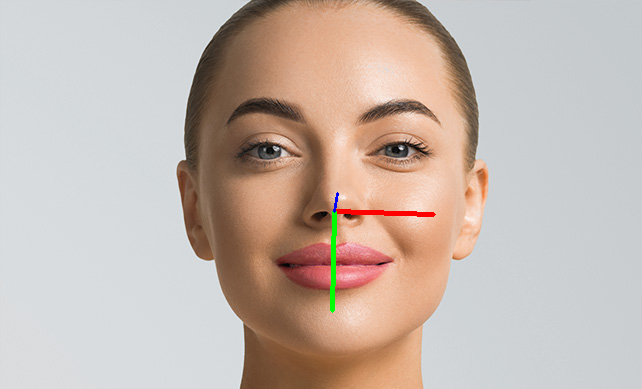

In [ ]:
cv2_imshow(draw_axis(image,pitch1,yaw1,roll1,nose[0]*image.shape[1],nose[1]*image.shape[0])) ## image and angles

In [ ]:
new = {}

faceModule = mediapipe.solutions.face_mesh
with faceModule.FaceMesh(static_image_mode=True) as faces:
      try:
        picture = 'Face2.png'

        new[picture] = {}
        image = cv2.imread('/content/Face2.png')
        results1 = faces.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        if results1.multi_face_landmarks != None:
          for face in results1.multi_face_landmarks:
              for i,landmark in enumerate(face.landmark):
                  x = landmark.x
                  y = landmark.y
                  if i ==1:
                    nose=(x,y)

                  new[picture]["x_"+str(i)] = x
                  new[picture]["y_"+str(i)] = y

      except:
        pass

In [ ]:
dframe2 = pd.DataFrame.from_dict(new,orient='index').reset_index()
dframe2

,index,x_0,y_0,x_1,y_1,x_2,y_2,x_3,y_3,x_4,...,x_463,y_463,x_464,y_464,x_465,y_465,x_466,y_466,x_467,y_467
0,nn.png,0.357599,0.641721,0.318891,0.529798,0.357244,0.565308,0.319275,0.430429,0.314335,...,0.48036,0.347219,0.457449,0.356344,0.438945,0.362241,0.64572,0.322802,0.666409,0.305105


In [ ]:
features2=dframe2.drop(df.columns[0], axis=1)

In [ ]:
dframe2.shape

(1, 937)

In [ ]:
pitch2 = best_pitch.predict(features2) ##for pitch

In [ ]:
yaw2 = best_yaw.predict(features2) ##for yaw

In [ ]:
roll2 = best_roll.predict(features2) ##for roll

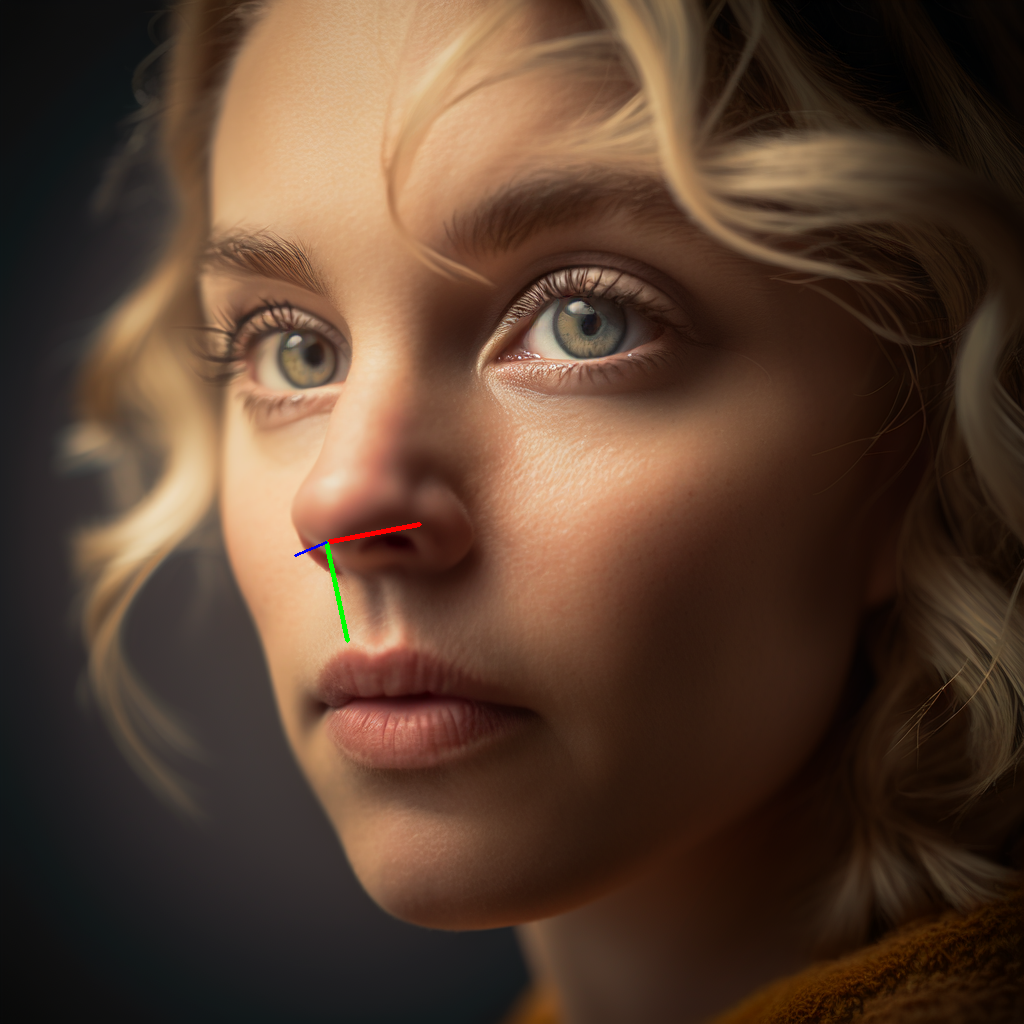

In [ ]:
cv2_imshow(draw_axis(image,pitch2,yaw2,roll2,nose[0]*image.shape[1],nose[1]*image.shape[0])) ## image and angles

Using the models on a video

In [ ]:
uploaded = files.upload()

video_filename = next(iter(uploaded))
cap = cv2.VideoCapture(video_filename)

new = {}
faceModule = mediapipe.solutions.face_mesh

total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
empty_start_time = None
fourcc = cv2.VideoWriter_fourcc(*'XVID')
output_video = cv2.VideoWriter('output_video.avi', fourcc, 30.0, (int(cap.get(3)), int(cap.get(4))))
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(cap.get(cv2.CAP_PROP_FPS))

out = cv2.VideoWriter('video1.wmv', cv2.VideoWriter_fourcc(*'WMV2'), fps, (frame_width, frame_height))


while cap.isOpened():
    ret, frame = cap.read()
    current_frame = int(cap.get(cv2.CAP_PROP_POS_FRAMES))

    if not ret or current_frame == total_frames:
        break  # Exit the loop if end of video

    with faceModule.FaceMesh(static_image_mode=True) as faces:
        new["pic"] = {}
        results1 = faces.process(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

        if results1.multi_face_landmarks is not None:
            empty_start_time = None  # Reset empty start time if faces are detected

            for face in results1.multi_face_landmarks:
                for i, landmark in enumerate(face.landmark):
                    x = landmark.x
                    y = landmark.y
                    if i == 1:
                        nose = (x, y)
                    new["pic"]["x_"+str(i)] = x
                    new["pic"]["y_"+str(i)] = y
        else:
            if empty_start_time is None:
                empty_start_time = time.time()  # Record start time when faces are not detected

            elif time.time() - empty_start_time > 5:
                break  # Exit the loop if no faces detected for more than 5 seconds

        dframe_v = pd.DataFrame.from_dict(new, orient='index').reset_index()
        features_v = dframe_v.drop(dframe_v.columns[0], axis=1)

        if features_v.empty:
            break  # Exit the loop if no faces detected

        pitch_v = best_pitch.predict(features_v)  # for pitch
        yaw_v = best_yaw.predict(features_v)  # for yaw
        roll_v = best_roll.predict(features_v)  # for roll
        frame_angles = draw_axis(frame, pitch_v, yaw_v, roll_v, nose[0] * frame.shape[1], nose[1] * frame.shape[0])  # draw angles on frame

        output_video.write(frame_angles)

cap.release()
output_video.release()
cv2.destroyAllWindows()
files.download('output_video.avi')


Saving newww.wmv to newww.wmv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>